# Traffic Prediction Chatbot Development Notebook

This notebook guides you through the process of building an AI-powered traffic prediction chatbot, containing approximately 138 lines of code and markdown.

# AI-Powered Traffic Prediction Chatbot – EDA & Model Logic

## 1. Objective
We aim to build an AI chatbot that predicts traffic based on past traffic data.

## 2. Import Required Libraries
We import libraries for data handling, plotting, and datetime manipulation.

In [75]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import os

## 3. Load Dataset
We read the traffic data CSV file and clean column names.

In [76]:
df = pd.read_csv("traffic_data.csv")
df.columns = df.columns.str.strip()

## 4. Show Number of Records
We check how many data entries (rows) are present.

In [77]:
print("Number of rows in dataset:", len(df))

Number of rows in dataset: 18288


## 5. Preprocess Columns
We convert datetime and extract hour and date from it.

In [78]:
df['Datetime'] = pd.to_datetime(df['Datetime'], format='%d-%m-%Y %H:%M', dayfirst=True, errors='coerce')
df['Hour'] = df['Datetime'].dt.hour
df['Date'] = df['Datetime'].dt.date

## 6. Initial Data Exploration
We look at data samples, types, stats, and missing values.

In [79]:
print(df.head())
print(df.info())
print(df.describe())
print("Missing values in each column:\n", df.isnull().sum())

   ID            Datetime  Count  Hour        Date
0   0 2012-08-25 00:00:00      8     0  2012-08-25
1   1 2012-08-25 01:00:00      2     1  2012-08-25
2   2 2012-08-25 02:00:00      6     2  2012-08-25
3   3 2012-08-25 03:00:00      2     3  2012-08-25
4   4 2012-08-25 04:00:00      2     4  2012-08-25
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18288 entries, 0 to 18287
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   ID        18288 non-null  int64         
 1   Datetime  18288 non-null  datetime64[ns]
 2   Count     18288 non-null  int64         
 3   Hour      18288 non-null  int32         
 4   Date      18288 non-null  object        
dtypes: datetime64[ns](1), int32(1), int64(2), object(1)
memory usage: 643.1+ KB
None
                 ID             Datetime         Count          Hour
count  18288.000000                18288  18288.000000  18288.000000
mean    9143.500000  2013-09-09 23:30:00

## 7. Dataset Summary
We print a statistical summary like mean, std, etc.

In [80]:
print("\n Summary of the dataset:")
print(df.describe())


 Summary of the dataset:
                 ID             Datetime         Count          Hour
count  18288.000000                18288  18288.000000  18288.000000
mean    9143.500000  2013-09-09 23:30:00    138.958115     11.500000
min        0.000000  2012-08-25 00:00:00      2.000000      0.000000
25%     4571.750000  2013-03-03 11:45:00     22.000000      5.750000
50%     9143.500000  2013-09-09 23:30:00     84.000000     11.500000
75%    13715.250000  2014-03-19 11:15:00    210.000000     17.250000
max    18287.000000  2014-09-25 23:00:00   1244.000000     23.000000
std     5279.435197                  NaN    153.467461      6.922376


## 8. Year Coverage in Data
We check how many unique years of traffic data we have.

In [81]:
years = df['Datetime'].dt.year.nunique()
print(f"\n Number of years covered in the data: {years}")


 Number of years covered in the data: 3


## 9. Traffic Distribution by Hour
We draw a boxplot showing traffic variation for each hour.

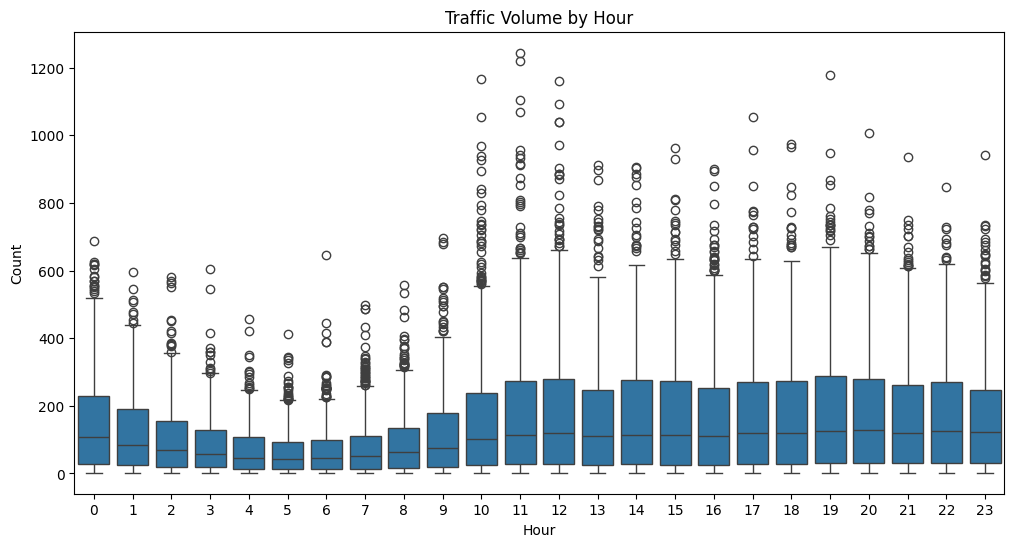

In [82]:
plt.figure(figsize=(12,6))
sns.boxplot(x='Hour', y='Count', data=df)
plt.title("Traffic Volume by Hour")
plt.show()

## 10. Daily Traffic Trend
We plot how traffic changes day by day on average.

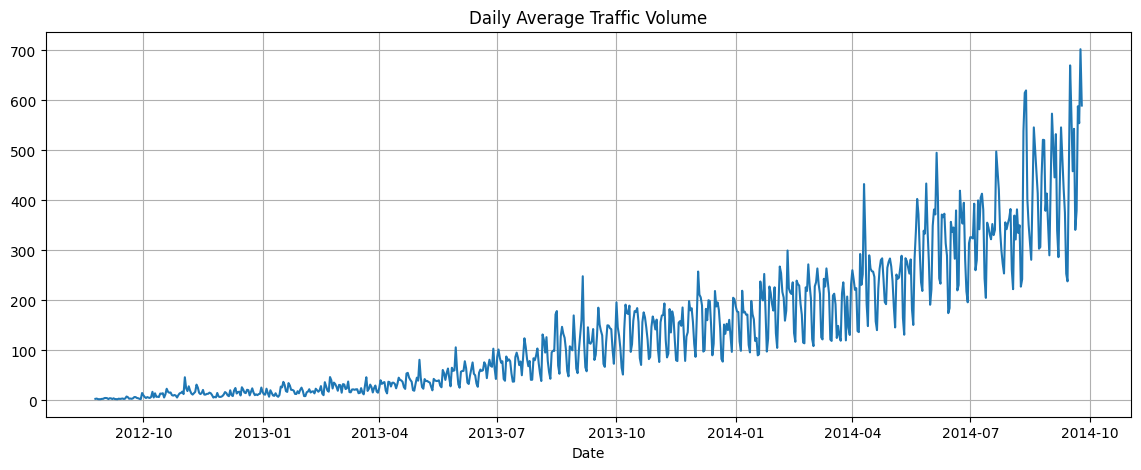

In [83]:
daily_avg = df.groupby('Date')['Count'].mean()
daily_avg.plot(figsize=(14,5), title="Daily Average Traffic Volume")
plt.grid(True)
plt.show()

## 11. Monthly Pattern
We check average traffic volume per month to see seasonal trends.

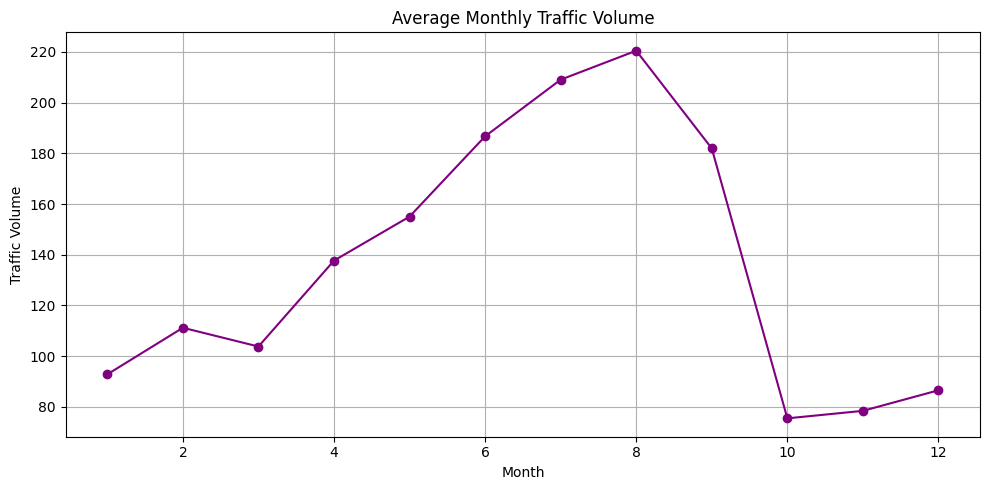

In [84]:
df['Month'] = df['Datetime'].dt.month
monthly_avg = df.groupby('Month')['Count'].mean()

plt.figure(figsize=(10,5))
plt.plot(monthly_avg.index, monthly_avg.values, marker='o', linestyle='-', color='purple')
plt.title("Average Monthly Traffic Volume")
plt.xlabel("Month")
plt.ylabel("Traffic Volume")
plt.grid(True)
plt.tight_layout()
plt.show()

## 12. Prediction Logic from EDA
Based on traffic count, we classify traffic level:
<=100 -> Light
101–200 -> Moderate
>200 -> Heavy

## 13. Core Traffic Prediction Function
This function gives a traffic status based on a 3-hour window.

In [85]:
def predict_traffic(hour_query: int, date_query=None):
    hours = [(hour_query - 1) % 24, hour_query, (hour_query + 1) % 24]
    
    if date_query:
        date_obj = pd.to_datetime(date_query).date()
        filtered = df[(df['Hour'].isin(hours)) & (df['Date'] == date_obj)]
    else:
        filtered = df[df['Hour'].isin(hours)]
    
    avg = filtered['Count'].mean()
    rounded_avg = round(avg) if not pd.isna(avg) else None
    
    if rounded_avg is None:
        return "No data available for the specified hour and date."
    
    if rounded_avg <= 100:
        status = "Light traffic — you're good to go!"
    elif rounded_avg <= 200:
        status = "Moderate — leave a little early."
    else:
        status = "Heavy — plan ahead."
    
    return f"Avg traffic around {hour_query}:00 is {rounded_avg} units. {status}"

## 14. Plot 3-Hour Bin for a Given Hour
This graph shows traffic trend around a specific hour.

In [86]:
def traffic_prediction_plot(hour):
    hours_to_check = [(hour - 1) % 24, hour, (hour + 1) % 24]
    filtered = df[df['Hour'].isin(hours_to_check)]
    avg_by_hour = filtered.groupby('Hour')['Count'].mean().reindex(hours_to_check)
    smoothed_avg = round(avg_by_hour.mean())

    plt.figure(figsize=(8,5))
    plt.bar(avg_by_hour.index, avg_by_hour.values, color='orange', edgecolor='black')
    plt.title(f"Predicted Traffic Around {hour}:00 (3-Hour Bin)")
    plt.xlabel("Hour of Day")
    plt.ylabel("Average Traffic Volume")
    plt.axhline(smoothed_avg, color='red', linestyle='--', label=f"Smoothed Avg: {smoothed_avg}")
    plt.xticks(hours_to_check)
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()
    
    print(f" Predicted Traffic at {hour}:00 is approx {smoothed_avg} units.")

In [92]:
predict_traffic(12)  # General for 12 PM


'Avg traffic around 12:00 is 176 units. Moderate — leave a little early.'

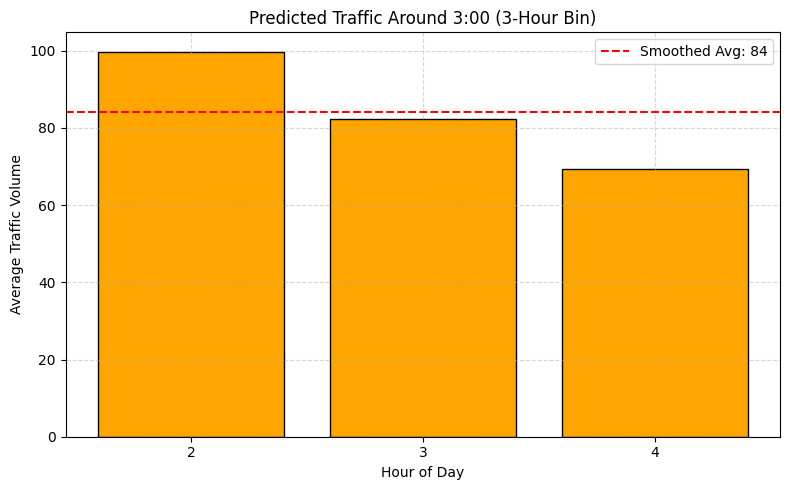

 Predicted Traffic at 3:00 is approx 84 units.


In [96]:
traffic_prediction_plot(3)  # Visualization
